In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

def load_trained_model(model_path):
    """Load the trained model from a file."""
    return load_model(model_path)

def preprocess_image(image_path, target_size):
    """Preprocess the input image before passing it to the model."""
    # Load image and convert to RGB
    image = np.array(Image.open(image_path).convert("RGB"))
    # Resize the image
    image = resize_image(image, target_size)
    # Normalize the image (same as the training preprocessing)
    image = image.astype(np.float32) / 255.0  # Normalizing to [0, 1]
    # Add batch dimension
    image = np.expand_dims(image, axis=0)
    return image

def predict_mask(model, image_path, target_size):
    """Predict the segmentation mask for a given image."""
    # Preprocess the image
    image = preprocess_image(image_path, target_size)

    # Perform inference
    prediction = model.predict(image)

    # Get the predicted mask (argmax across channels to select the class with the highest probability)
    predicted_mask = np.argmax(prediction, axis=-1)
    # Remove batch dimension and expand to match mask shape
    predicted_mask = np.squeeze(predicted_mask, axis=0)

    return predicted_mask

def display_mask(predicted_mask, target_size):
    """Display the predicted mask using PIL."""
    # Convert the mask to an image
    mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    mask_image = mask_image.resize(target_size, Image.Resampling.LANCZOS)
    mask_image.show()


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_image_and_mask(image_path, predicted_mask, target_size):
    """Visualize the original image and its predicted mask side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Convert predicted mask to an image for visualization
    mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    mask_image = mask_image.resize(target_size, Image.Resampling.LANCZOS)

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(mask_image, cmap='jet')  # Use a color map for better visualization of the mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()




In [11]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

def resize_image(image, target_size):
    """Resize the image to the target size using PIL."""
    return np.array(Image.fromarray(image).resize(target_size, Image.Resampling.LANCZOS))

class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size, image_folder, mask_folder, patch_size, num_classes=8, augment=False):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.augment = augment  # Augmentation flag (not used now)
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_images = self.image_files[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_files[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []
        for img_file, mask_file in zip(batch_images, batch_masks):
            # Load and preprocess image
            image = np.array(Image.open(os.path.join(self.image_folder, img_file)).convert("RGB"))
            image = resize_image(image, (self.patch_size, self.patch_size))  # Resize image

            # Load and preprocess mask
            mask = np.array(Image.open(os.path.join(self.mask_folder, mask_file)).convert("L"))
            mask = resize_image(mask, (self.patch_size, self.patch_size))  # Resize mask
            mask = one_hot_encode_mask(mask, num_classes=self.num_classes)

            images.append(image)
            masks.append(mask)

        images = np.array(images).astype(np.float32)
        masks = np.array(masks).astype(np.float32)

        return images, masks

    def on_epoch_end(self):
        combined = list(zip(self.image_files, self.mask_files))
        np.random.shuffle(combined)
        self.image_files, self.mask_files = zip(*combined)


def one_hot_encode_mask(mask, num_classes):
    """Convert a grayscale mask to a one-hot encoded format."""
    one_hot = np.zeros((mask.shape[0], mask.shape[1], num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot[:, :, c] = (mask == c).astype(np.float32)
    return one_hot


# U-Net Model with VGG16 Encoder
def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.Concatenate()([x, skip_features])
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    x = layers.Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
    return x

def build_unet_vgg16(input_shape, num_classes):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in vgg16.layers:
        layer.trainable = False  # Freeze the layers initially

    s1 = vgg16.get_layer('block1_conv2').output
    s2 = vgg16.get_layer('block2_conv2').output
    s3 = vgg16.get_layer('block3_conv3').output
    s4 = vgg16.get_layer('block4_conv3').output
    p4 = vgg16.get_layer('block5_conv3').output

    d1 = decoder_block(p4, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Add batch normalization after each convolution layer
    d4 = layers.BatchNormalization()(d4)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d4)
    return Model(inputs=vgg16.input, outputs=outputs)


# Paths
image_folder = '/content/drive/MyDrive/originals'
mask_folder = '/content/drive/MyDrive/masks'
patch_size = 128

# File Lists
image_files = sorted(os.listdir(image_folder))
mask_files = sorted(os.listdir(mask_folder))

# Train-Test Split
train_images, val_images, train_masks, val_masks = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Data Generators without Augmentation
batch_size = 4
train_generator = DataGenerator(train_images, train_masks, batch_size, image_folder, mask_folder, patch_size, augment=False)
val_generator = DataGenerator(val_images, val_masks, batch_size, image_folder, mask_folder, patch_size, augment=False)

# Build Model
input_shape = (patch_size, patch_size, 3)
num_classes = 8
model = build_unet_vgg16(input_shape, num_classes)

# Compile Model with Dice Loss
@register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1 - (2. * intersection + smooth) / (union + smooth)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=dice_loss,
    metrics=['accuracy', MeanIoU(num_classes=num_classes)]
)

# Callbacks
checkpoint = ModelCheckpoint('unet_model_best.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train Model with additional callbacks
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1000,
        callbacks=[checkpoint, early_stopping, lr_scheduler]
    )

# Save Final Model
model.save('final_unet_model.keras')


# Usage example for prediction and visualization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_image_and_mask(image_path, predicted_mask, target_size):
    """Visualize the original image and its predicted mask side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Convert predicted mask to an image for visualization
    mask_image = Image.fromarray(predicted_mask.astype(np.uint8))
    mask_image = mask_image.resize(target_size, Image.Resampling.LANCZOS)

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(mask_image, cmap='jet')  # Use a color map for better visualization of the mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Load the trained model
model = load_model('final_unet_model.keras')

# Predict the mask for an image
image_path = '/content/Shisper_2023_June_5.jpg'  # Replace with actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size))


Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 655ms/step - accuracy: 0.2854 - loss: 0.7445 - mean_io_u_3: 0.4375 - val_accuracy: 0.3526 - val_loss: 0.6546 - val_mean_io_u_3: 0.5099 - learning_rate: 0.0010
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 666ms/step - accuracy: 0.4591 - loss: 0.5606 - mean_io_u_3: 0.4381 - val_accuracy: 0.4992 - val_loss: 0.5155 - val_mean_io_u_3: 0.4876 - learning_rate: 0.0010
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.4694 - loss: 0.5393 - mean_io_u_3: 0.4480 - val_accuracy: 0.4891 - val_loss: 0.5134 - val_mean_io_u_3: 0.5823 - learning_rate: 0.0010
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 560ms/step - accuracy: 0.4721 - loss: 0.5326 - mean_io_u_3: 0.4603 - val_accuracy: 0.5290 - val_loss: 0.4749 - val_mean_io_u_3: 0.5529 - learning_rate: 0.0010
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.4786 - loss: 0.5262 - mean_io_u_3: 0.4560 - val_accuracy: 0.5184 - val_loss: 0.4896 - val_mean_io_u_3: 0.4955 - learning_r

FileNotFoundError: [Errno 2] No such file or directory: '/content/Shisper_2023_June_5.jpg'

In [23]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('final_unet_model.keras', custom_objects={'dice_loss': dice_loss, 'MeanIoU': MeanIoU})


In [31]:
# Get the last epoch's training loss and accuracy
last_epoch_loss = history.history['loss'][-1]
last_epoch_accuracy = history.history['accuracy'][-1]

# Convert to percentage format
last_epoch_loss_percentage = last_epoch_loss * 100
last_epoch_accuracy_percentage = last_epoch_accuracy * 100

# Print the results for the last epoch
print(f"Training Loss (last epoch): {last_epoch_loss_percentage:.2f}%")
print(f"Training Accuracy (last epoch): {last_epoch_accuracy_percentage:.2f}%")

# If you want to get the mean of the training accuracy and loss over all epochs
mean_training_loss = np.mean(history.history['loss']) * 100
mean_training_accuracy = np.mean(history.history['accuracy']) * 100

# Print the mean values for training metrics
print(f"Mean Training Loss: {mean_training_loss:.2f}%")
print(f"Mean Training Accuracy: {mean_training_accuracy:.2f}%")

# Evaluate the model on the validation set to get validation metrics
val_loss, val_accuracy, val_mean_iou = model.evaluate(val_generator)

# Convert validation metrics to percentages
val_loss_percentage = val_loss * 100
val_accuracy_percentage = val_accuracy * 100
val_mean_iou_percentage = val_mean_iou * 100

# Print the validation results
print(f"Validation Loss: {val_loss_percentage:.2f}%")
print(f"Validation Accuracy: {val_accuracy_percentage:.2f}%")
print(f"Validation Mean IoU: {val_mean_iou_percentage:.2f}%")

# Optionally, you can also print the mean of validation loss, accuracy, and IoU if tracked during training
mean_val_loss = np.mean(history.history['val_loss']) * 100
mean_val_accuracy = np.mean(history.history['val_accuracy']) * 100
mean_val_iou = np.mean(history.history['val_mean_io_u_3']) * 100  # Use the correct key for Mean IoU

print(f"Mean Validation Loss: {mean_val_loss:.2f}%")
print(f"Mean Validation Accuracy: {mean_val_accuracy:.2f}%")
print(f"Mean Validation IoU: {mean_val_iou:.2f}%")



Training Loss (last epoch): 9.05%
Training Accuracy (last epoch): 91.15%
Mean Training Loss: 20.61%
Mean Training Accuracy: 80.29%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step - accuracy: 0.9032 - loss: 0.0990 - mean_io_u_3: 0.6339
Validation Loss: 10.09%
Validation Accuracy: 90.12%
Validation Mean IoU: 63.07%
Mean Validation Loss: nan%
Mean Validation Accuracy: 79.06%
Mean Validation IoU: 59.25%


Training Loss (last epoch): 9.05%
Training Accuracy (last epoch): 91.15%
Mean Training Loss: 20.61%
Mean Training Accuracy: 80.29%
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - accuracy: 0.8677 - loss: 0.1343 - mean_io_u_3: 0.6385
Validation Loss: 12.72%
Validation Accuracy: 87.48%
Validation Mean IoU: 63.67%
Mean Validation Loss: nan%
Mean Validation Accuracy: 79.06%
Mean Validation IoU: 59.25%


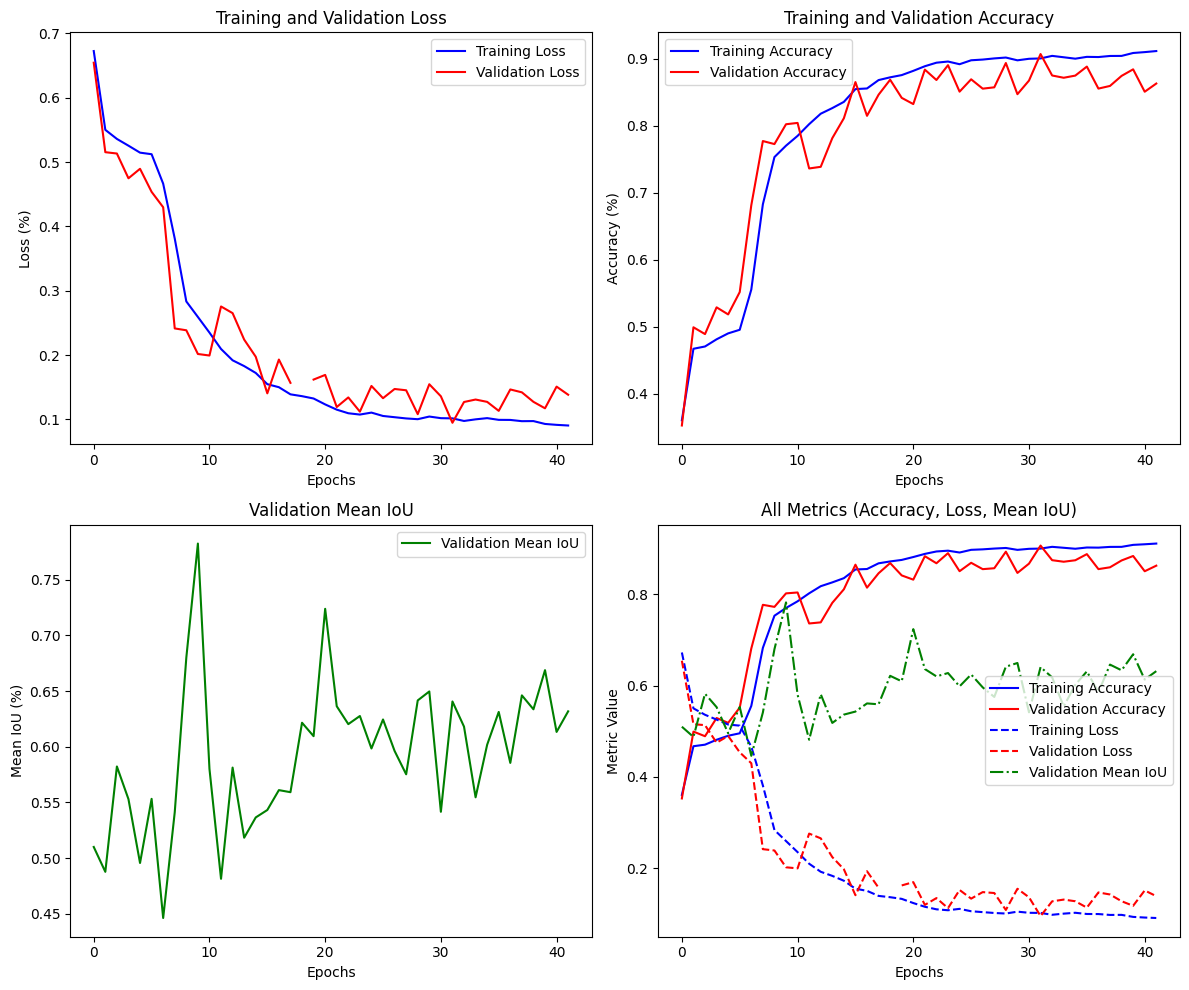

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Get the last epoch's training loss and accuracy
last_epoch_loss = history.history['loss'][-1]
last_epoch_accuracy = history.history['accuracy'][-1]

# Convert to percentage format
last_epoch_loss_percentage = last_epoch_loss * 100
last_epoch_accuracy_percentage = last_epoch_accuracy * 100

# Print the results for the last epoch
print(f"Training Loss (last epoch): {last_epoch_loss_percentage:.2f}%")
print(f"Training Accuracy (last epoch): {last_epoch_accuracy_percentage:.2f}%")

# If you want to get the mean of the training accuracy and loss over all epochs
mean_training_loss = np.mean(history.history['loss']) * 100
mean_training_accuracy = np.mean(history.history['accuracy']) * 100

# Print the mean values for training metrics
print(f"Mean Training Loss: {mean_training_loss:.2f}%")
print(f"Mean Training Accuracy: {mean_training_accuracy:.2f}%")

# Evaluate the model on the validation set to get validation metrics
val_loss, val_accuracy, val_mean_iou = model.evaluate(val_generator)

# Convert validation metrics to percentages
val_loss_percentage = val_loss * 100
val_accuracy_percentage = val_accuracy * 100
val_mean_iou_percentage = val_mean_iou * 100

# Print the validation results
print(f"Validation Loss: {val_loss_percentage:.2f}%")
print(f"Validation Accuracy: {val_accuracy_percentage:.2f}%")
print(f"Validation Mean IoU: {val_mean_iou_percentage:.2f}%")

# Optionally, you can also print the mean of validation loss, accuracy, and IoU if tracked during training
mean_val_loss = np.mean(history.history['val_loss']) * 100
mean_val_accuracy = np.mean(history.history['val_accuracy']) * 100
mean_val_iou = np.mean(history.history['val_mean_io_u_3']) * 100  # Use the correct key for Mean IoU

print(f"Mean Validation Loss: {mean_val_loss:.2f}%")
print(f"Mean Validation Accuracy: {mean_val_accuracy:.2f}%")
print(f"Mean Validation IoU: {mean_val_iou:.2f}%")

# Plot the metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Training Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss (%)')
axes[0, 0].legend()

# Plot Training Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()

# Plot Validation Mean IoU
axes[1, 0].plot(history.history['val_mean_io_u_3'], label='Validation Mean IoU', color='green')
axes[1, 0].set_title('Validation Mean IoU')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Mean IoU (%)')
axes[1, 0].legend()

# Plot all metrics (Loss, Accuracy, Mean IoU)
axes[1, 1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[1, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1, 1].plot(history.history['loss'], label='Training Loss', color='blue', linestyle='--')
axes[1, 1].plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
axes[1, 1].plot(history.history['val_mean_io_u_3'], label='Validation Mean IoU', color='green', linestyle='-.')
axes[1, 1].set_title('All Metrics (Accuracy, Loss, Mean IoU)')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Metric Value')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


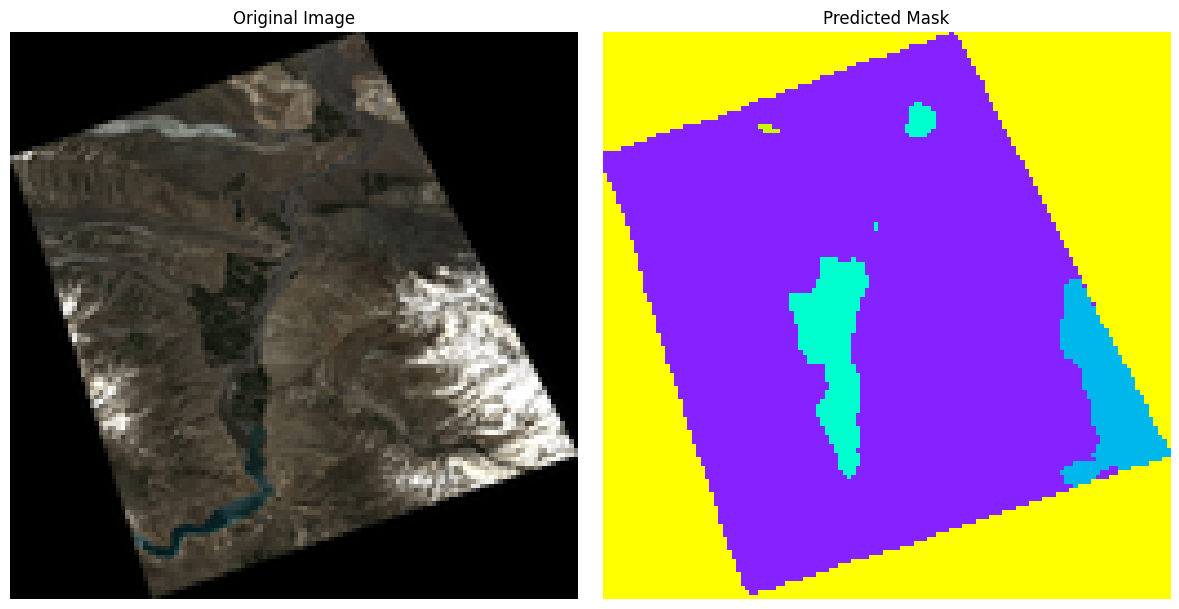

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_5.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


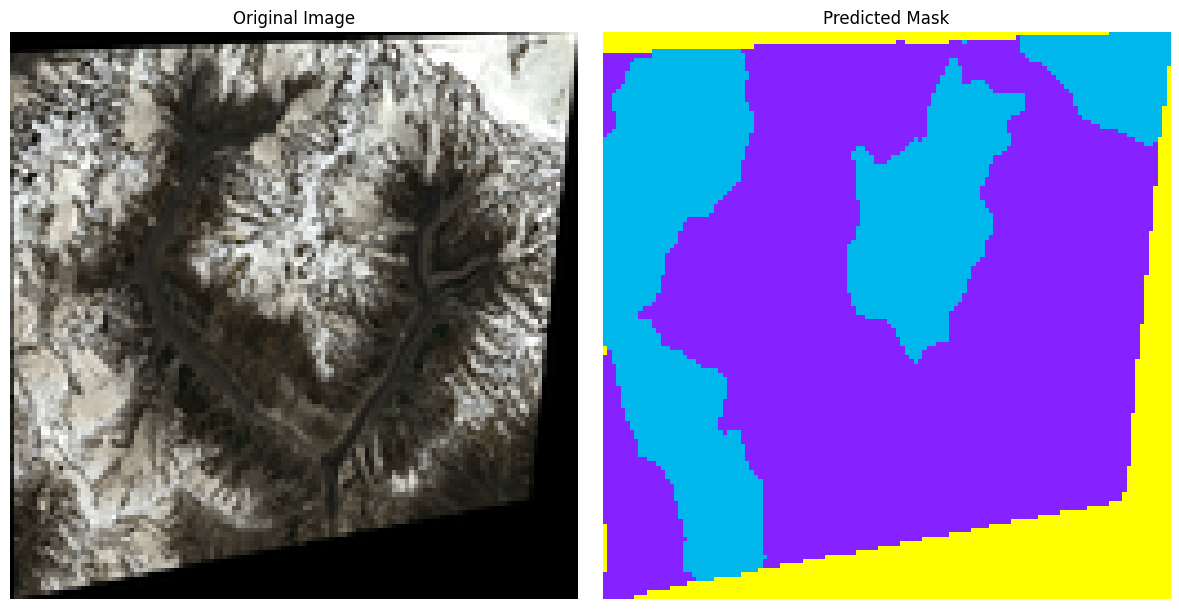

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_1.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


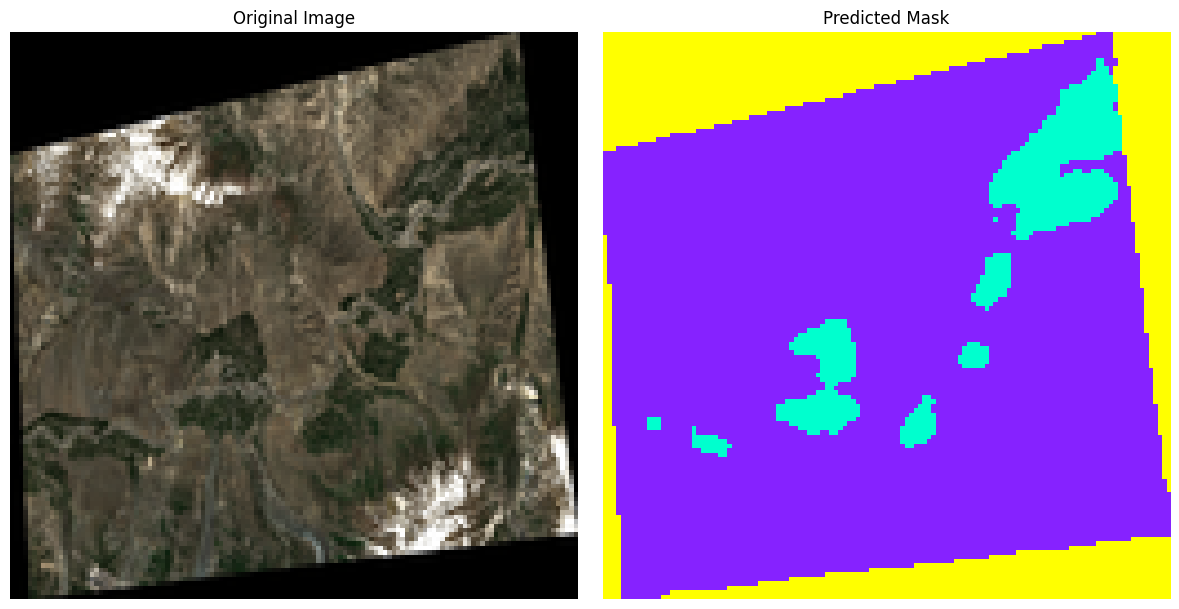

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_2.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


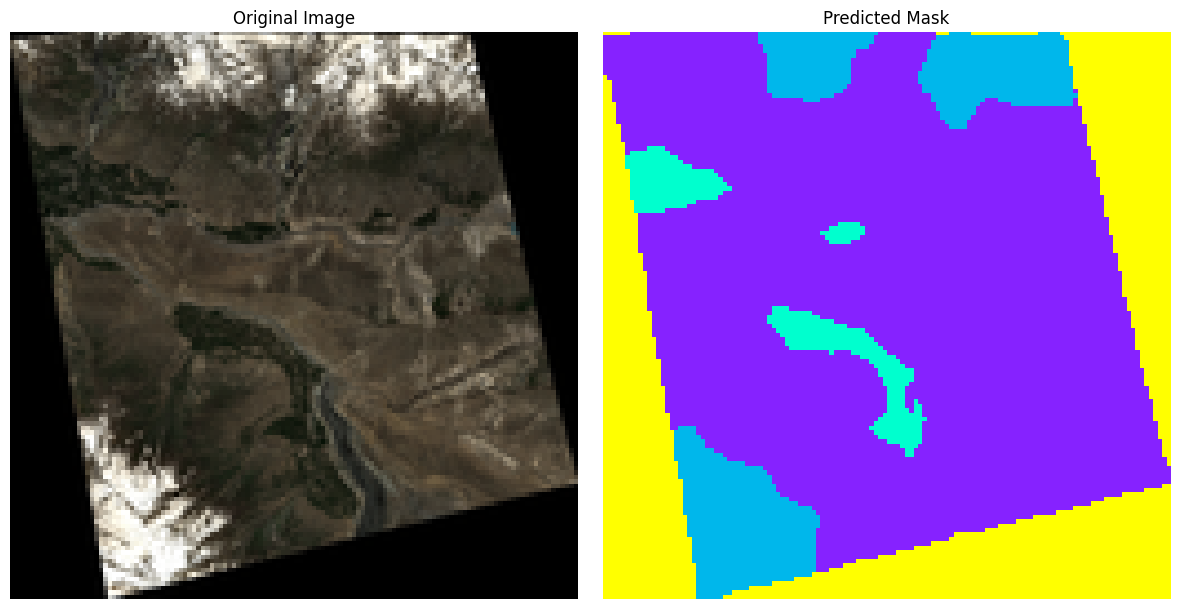

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_3.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


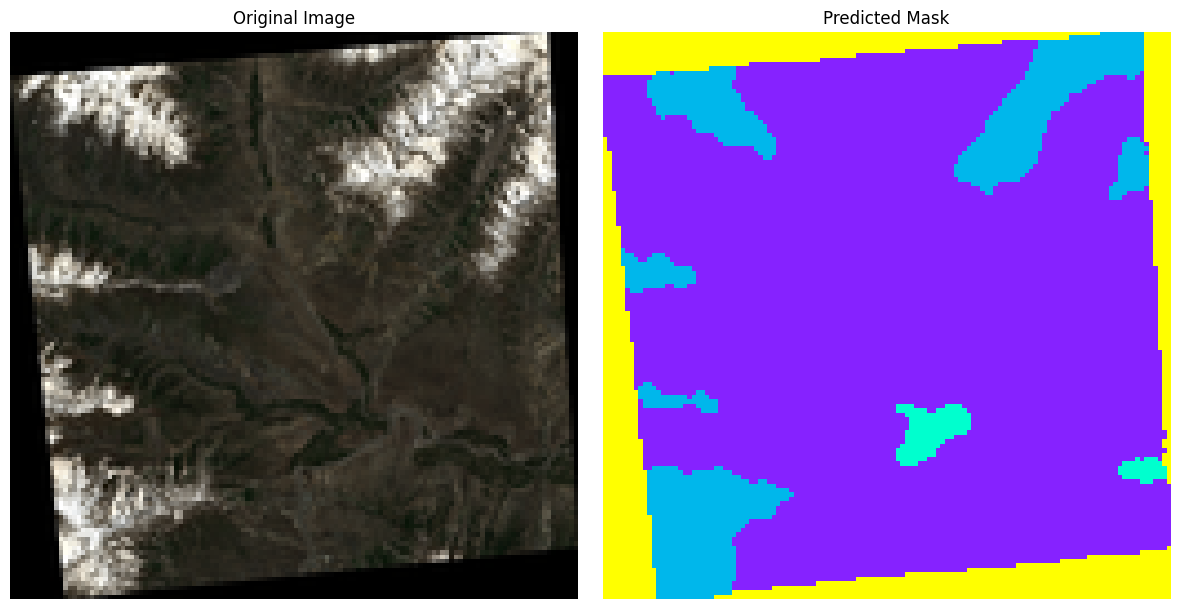

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_4.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


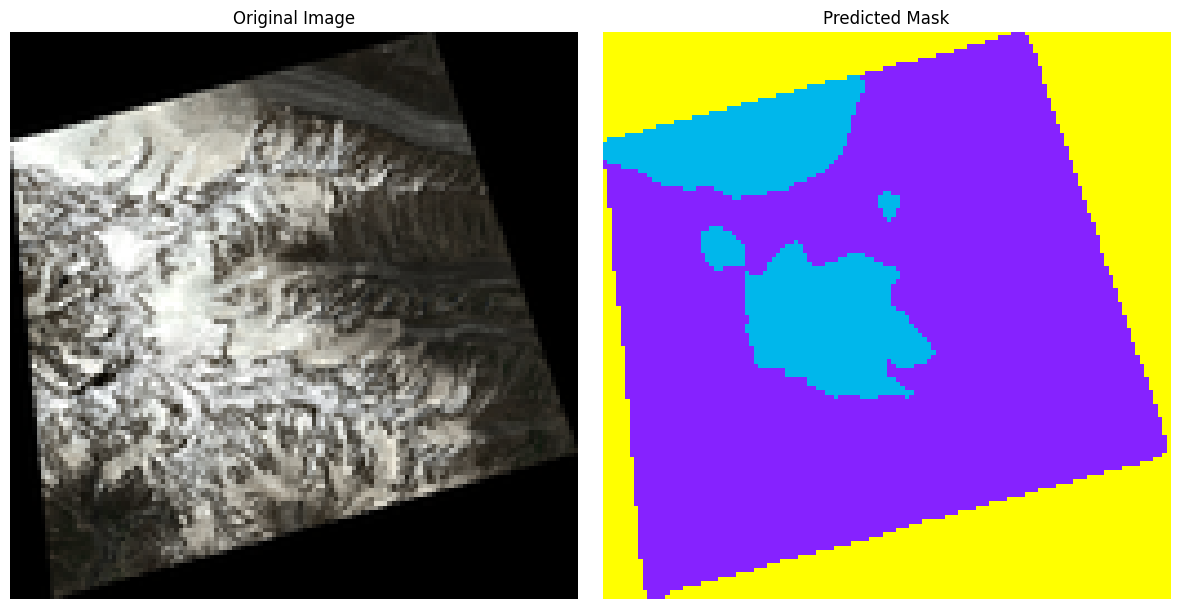

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

# Define the color map for classes
color_map = {
    0: (255, 255, 0),  # Background
    1: (199, 252, 0),  # Glacier
    2: (254, 0, 86),   # House_Building
    3: (0, 183, 235),  # Ice
    4: (134, 34, 255), # Land
    5: (255, 255, 0),  # Undefined
    6: (0, 255, 206),  # Vegetation
    7: (255, 128, 0),  # Water
}

def visualize_image_and_mask(image_path, predicted_mask, target_size, num_classes):
    """Visualize the original image and its predicted mask with colored classes side by side."""
    # Load the original image
    original_image = Image.open(image_path).convert("RGB")
    original_image = original_image.resize(target_size, Image.Resampling.LANCZOS)

    # Apply color to the predicted mask based on the color map
    colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)

    for class_idx in range(num_classes):
        # Create a binary mask for each class
        class_mask = (predicted_mask == class_idx).astype(np.uint8)
        colored_mask[class_mask == 1] = color_map[class_idx]  # Map the class index to a color from the color_map

    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(colored_mask)  # Display the colored mask
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

# Example function to get the predicted mask from the model (assuming it's a segmentation problem)
def predict_mask(model, image_path, target_size):
    """Predict the mask for a given image using the trained model."""
    # Load and preprocess image
    image = np.array(Image.open(image_path).convert("RGB"))
    image = resize_image(image, target_size)  # Resize image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict mask
    predicted_mask = model.predict(image)

    # Convert from one-hot encoding to class map
    predicted_mask = np.argmax(predicted_mask, axis=-1)  # Convert the one-hot encoded output to a single class label per pixel
    predicted_mask = np.squeeze(predicted_mask, axis=0)  # Remove batch dimension

    return predicted_mask

# Example usage
image_path = '/content/Shisper_2023_June_6.jpg'  # Replace with your actual image path
predicted_mask = predict_mask(model, image_path, target_size=(patch_size, patch_size))

# Visualize the image and its predicted mask
visualize_image_and_mask(image_path, predicted_mask, target_size=(patch_size, patch_size), num_classes=8)
